In this notebook, I will be doing EDA, feature engineering, and final dataset preparation for model building.  

Retrieving the saved dataset from the last notebook.

In [ ]:
import pandas as pd

df = pd.read_csv("preprocessed_bioactivity_data.csv")

In [ ]:
df.head()

,molecule_chembl_id,standard_value,canonical_smiles,bioactivity_class
0,CHEMBL68920,41.0,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,active
1,CHEMBL69960,170.0,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,active
2,CHEMBL137635,9300.0,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,intermediate
3,CHEMBL306988,500000.0,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,inactive
4,CHEMBL66879,3000000.0,O=C(O)/C=C/c1ccc(O)cc1,inactive


#**Setting Up RDKit**

I used the following commands to install RDKit, a powerful cheminformatics library used for computing molecular descriptors and fingerprints:


(This will take some time...)

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2025-06-17 14:22:54--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’

Miniconda3-py37_4.8 100%[===================>]  81.12M   122MB/s    in 0.7s    

2025-06-17 14:22:55 (122 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_10

#Why RDKit?

RDKit is essential for:

- Generating molecular fingerprints

- Calculating physicochemical descriptors

- Handling SMILES and structure-based data

#Why conda?

RDKit has several C++ dependencies and is best installed via conda, which handles binary packages and dependencies more reliably than pip.

#**Calculate Lipinski descriptors**

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

- Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10

#Importing Libraries

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
def lipinski(smiles, verbose=False):

  moldata = []
  for elem in smiles:
    mol = Chem.MolFromSmiles(elem)
    moldata.append(mol)

  baseData = np.arange(1,1)
  i=0
  for mol in moldata:

    desc_MolWt = Descriptors.MolWt(mol)
    desc_MolLogP = Descriptors.MolLogP(mol)
    desc_NumHDonors = Lipinski.NumHDonors(mol)
    desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

    row = np.array([desc_MolWt,
                    desc_MolLogP,
                    desc_NumHDonors,
                    desc_NumHAcceptors])

    if(i==0):
      baseData = row
    else:
      baseData = np.vstack([baseData, row])
    i=i+1

  columnNames = ["MW","LogP","NumHDonors","NumHAcceptors"]
  descriptors = pd.DataFrame(data=baseData,columns=columnNames)

  return descriptors

Based on Lipinski's Rule of Five, these four descriptors are used to evaluate a compound’s oral bioavailability:

- MW: Molecular Weight

- LogP: Octanol-water partition coefficient (hydrophobicity)

- NumHDonors: Number of hydrogen bond donors

- NumHAcceptors: Number of hydrogen bond acceptors

These features are simple yet powerful indicators of drug-likeness, and I included them as part of the feature set for my classification model.

In [ ]:
df_lipinski = lipinski(df.canonical_smiles)

Dataset with molecular descriptors:

In [ ]:
df_lipinski.head()

,MW,LogP,NumHDonors,NumHAcceptors
0,383.814,4.45034,3.0,4.0
1,482.903,3.61432,3.0,6.0
2,369.432,4.77200,1.0,6.0
3,283.287,2.31056,2.0,4.0
4,164.160,1.49000,2.0,2.0


Dataset with standard_value, cannonical_smiles, 4 molecular descriptors, and the label:

In [ ]:
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined.head()

,molecule_chembl_id,standard_value,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL68920,41.0,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,active,383.814,4.45034,3.0,4.0
1,CHEMBL69960,170.0,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,active,482.903,3.61432,3.0,6.0
2,CHEMBL137635,9300.0,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,intermediate,369.432,4.77200,1.0,6.0
3,CHEMBL306988,500000.0,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,inactive,283.287,2.31056,2.0,4.0
4,CHEMBL66879,3000000.0,O=C(O)/C=C/c1ccc(O)cc1,inactive,164.160,1.49000,2.0,2.0


#Normalizing IC50 Values

To handle extremely large IC50 values that could skew the model, I capped them at a maximum of 100,000,000 nM and stored the result in a new column:

In [ ]:
def norm_value(input):
  norm = []

  for i in input['standard_value']:
    if i > 100000000:
      i = 100000000
    norm.append(i)

  input['standard_value_norm'] = norm
  x = input.drop('standard_value', axis=1)

  return x

This is done because:

- IC50 values can sometimes be excessively high due to experimental or reporting variations.

- Capping them helps reduce variance and outlier impact without losing essential bioactivity trends.

- I then dropped the original column to keep only the normalized values (standard_value_norm) for further processing.

In [ ]:
df_norm = norm_value(df_combined)
df_norm.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,active,383.814,4.45034,3.0,4.0,41.0
1,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,active,482.903,3.61432,3.0,6.0,170.0
2,CHEMBL137635,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,intermediate,369.432,4.77200,1.0,6.0,9300.0
3,CHEMBL306988,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,inactive,283.287,2.31056,2.0,4.0,500000.0
4,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,inactive,164.160,1.49000,2.0,2.0,3000000.0


In [ ]:
df_norm.standard_value_norm.describe()

,standard_value_norm
count,1.535000e+03
mean,3.734992e+04
std,2.454248e+05
min,3.000000e-03
25%,2.000000e+01
50%,2.690000e+02
75%,3.394220e+03
max,6.500000e+06


No value here is extremely big.

#**Converting IC50 to pIC50**

To make the target variable more suitable for machine learning models, I transformed the normalized IC50 values into pIC50:

In [ ]:
def pIC5O(input):
  pIC5O = []

  for i in input['standard_value_norm']:
    molar = i*(10**-9)
    pIC5O.append(-np.log10(molar))

  input['pIC5O'] = pIC5O
  X = input.drop('standard_value_norm', axis = 1)

  return X

#**Why pIC50?**

pIC50 = –log₁₀(IC50 in molar units)

It transforms skewed IC50 values into a logarithmic scale, which:

- Reduces the impact of outliers

- Improves model interpretability

- Aligns with how potency is commonly represented in drug discovery

- After the transformation, I dropped the raw standard_value_norm column and retained pIC5O as the new potency feature.

In [ ]:
df_final = pIC5O(df_norm)
df_final.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC5O
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,active,383.814,4.45034,3.0,4.0,7.387216
1,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,active,482.903,3.61432,3.0,6.0,6.769551
2,CHEMBL137635,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,intermediate,369.432,4.77200,1.0,6.0,5.031517
3,CHEMBL306988,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,inactive,283.287,2.31056,2.0,4.0,3.301030
4,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,inactive,164.160,1.49000,2.0,2.0,2.522879


In [ ]:
df_final.pIC5O.describe()

,pIC5O
count,1535.000000
mean,6.614280
std,1.573618
min,2.187087
25%,5.469261
50%,6.570248
75%,7.698970
max,11.522879


I removed compounds labeled as intermediate to simplify the task into a binary classification problem **(active vs inactive)**:

In [ ]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class.shape

(1239, 8)

This helps the model learn clearer distinctions between active and inactive molecules.

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

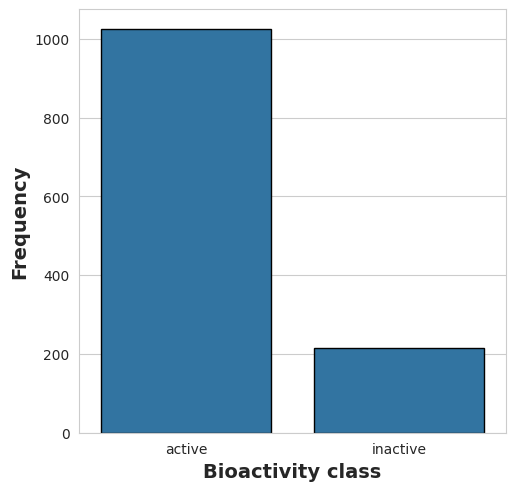

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

The dataset shows significant class imbalance, with ~1,000 active and only ~239 inactive compounds out of 1,239 total entries. This indicates that inactive EGFR inhibitors are relatively rare in the available data.

I will address this imbalance during the model building phase to ensure fair learning and avoid biased predictions toward the majority class.

#**Molecular Fingerprinting with RDKit**

To prepare molecular structures for machine learning, I converted each compound's SMILES into a fixed-length numerical vector using Morgan fingerprints (also known as Extended-Connectivity Fingerprints, or ECFP).

In [ ]:
from rdkit.Chem import AllChem

def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)

df_2class['fp'] = df_2class['canonical_smiles'].apply(smiles_to_fp)

<ipython-input-28-1571691613>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2class['fp'] = df_2class['canonical_smiles'].apply(smiles_to_fp)


#What Are Morgan Fingerprints?

Morgan fingerprints encode the local chemical environment of atoms in a molecule.

They are computed by:

- Starting from each atom

- Expanding outwards to a certain radius (in this case, radius = 2)

- Hashing each substructure into a specific position (bit) in a fixed-length binary vector (here, 1024 bits)

- Each bit position corresponds to a particular circular substructure, and its value (0 or 1) indicates whether that feature is present.

- Think of it like a molecular barcode that tells the model which parts of the molecule exist without needing 3D structures or expensive computations.

#Why Radius = 2 and nBits = 1024?

- Radius = 2 captures the substructure up to 2 bonds away from each atom — a good balance between local detail and generalization.

- 1024 bits provides sufficient resolution to avoid excessive bit collisions while keeping the feature size manageable.

#Why This Matters in Drug Discovery

- Bioactivity is driven by structural features — certain functional groups or ring systems increase or reduce binding affinity.

- Morgan fingerprints make it possible to represent this chemical structure in a form that machine learning algorithms can interpret and learn from.

- This representation is structure-agnostic (works for any molecule with a SMILES) and reproducible, making it a cornerstone in virtual screening and QSAR modeling.

In [ ]:
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC5O,fp
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,active,383.814,4.45034,3.0,4.0,7.387216,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,active,482.903,3.61432,3.0,6.0,6.769551,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,CHEMBL306988,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,inactive,283.287,2.31056,2.0,4.0,3.301030,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,inactive,164.160,1.49000,2.0,2.0,2.522879,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,CHEMBL77085,N#CC(C#N)=Cc1cc(O)ccc1[N+](=O)[O-],inactive,215.168,1.73096,1.0,5.0,4.017729,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
1530,CHEMBL394333,NCCOCc1ccn2ncnc(Nc3ccc4c(cnn4Cc4cccc(F)c4)c3)c12,active,431.475,3.48530,2.0,8.0,7.045757,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1531,CHEMBL246694,NC(=O)COCc1ccn2ncnc(Nc3ccc4c(cnn4Cc4cccc(F)c4)...,active,445.458,3.01190,2.0,8.0,6.853872,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1532,CHEMBL246491,COC(=O)COCc1ccn2ncnc(Nc3ccc4c(cnn4Cc4cccc(F)c4...,active,460.469,3.69960,1.0,9.0,6.337242,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1533,CHEMBL394057,O=C(O)COCc1ccn2ncnc(Nc3ccc4c(cnn4Cc4cccc(F)c4)...,active,446.442,3.61120,2.0,8.0,7.522879,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df_2class.describe()

,MW,LogP,NumHDonors,NumHAcceptors,pIC5O
count,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000
mean,397.568123,3.991514,1.957224,5.682809,6.820704
std,103.827736,1.367289,1.104672,1.674754,1.617782
min,130.150000,-1.980000,0.000000,1.000000,2.187087
25%,332.363000,3.250500,1.000000,5.000000,6.029195
50%,399.296000,4.012200,2.000000,6.000000,6.946922
75%,460.939000,4.739550,2.000000,7.000000,8.000000
max,766.898000,9.499000,10.000000,13.000000,11.522879


Visuaizing feature distributions and outlier presence:

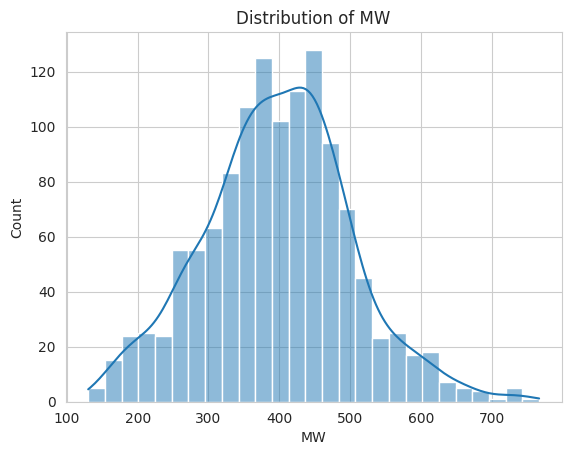

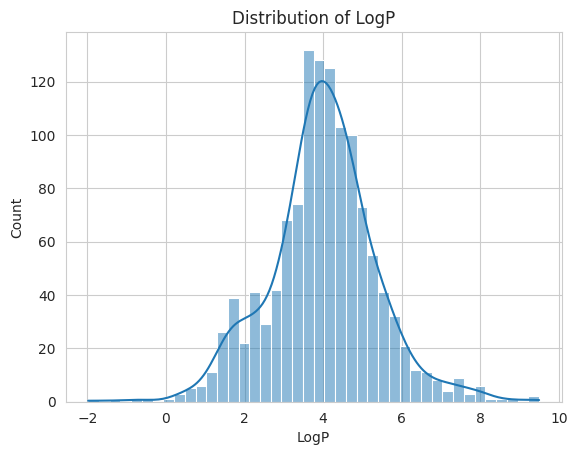

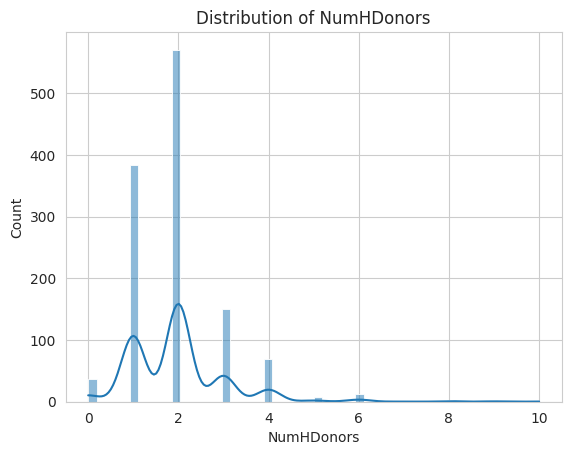

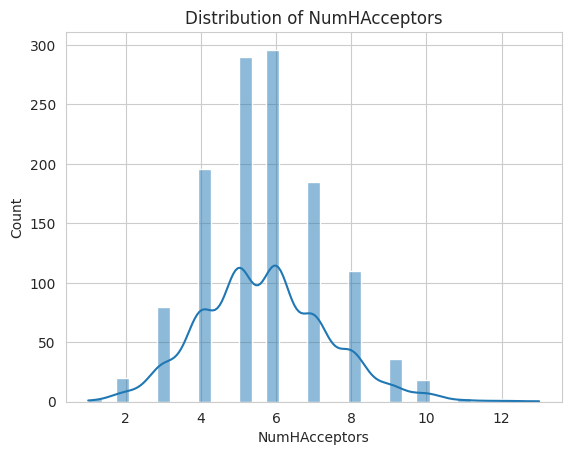

In [ ]:
features = ['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
for feature in features:
    sns.histplot(df_2class[feature], kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show();

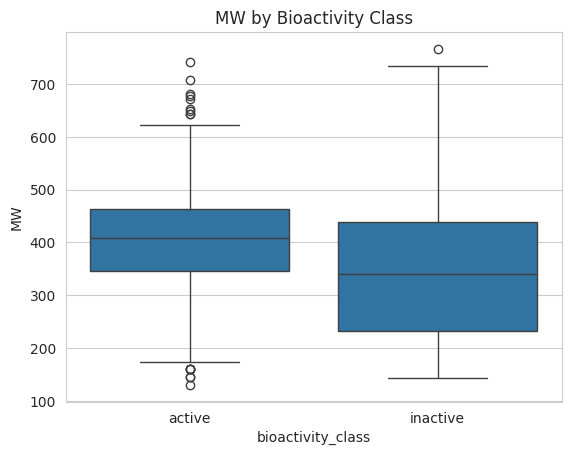

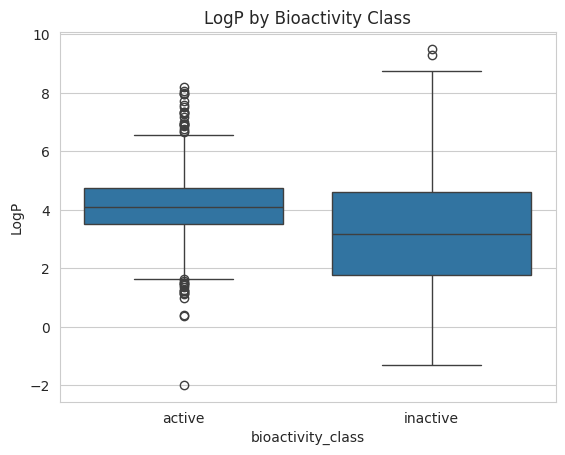

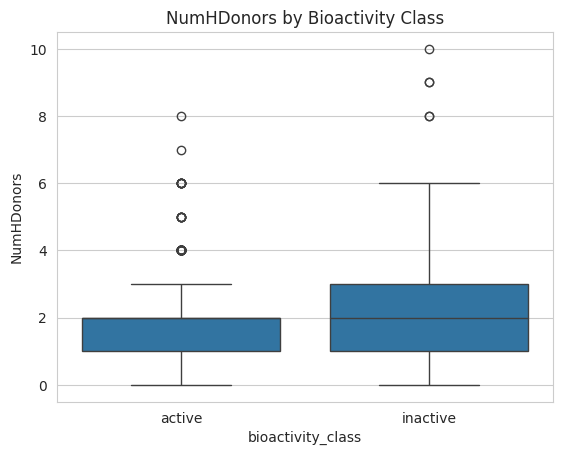

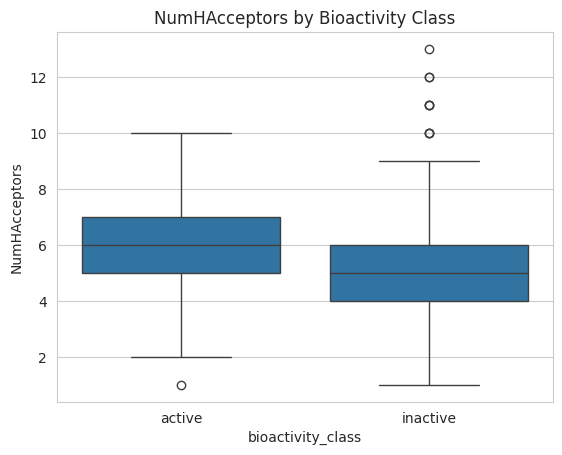

In [ ]:
for feature in features:
    sns.boxplot(data=df_2class, x='bioactivity_class', y=feature)
    plt.title(f"{feature} by Bioactivity Class")
    plt.show();

#**No Outlier Removal or Feature Normalization**

While many machine learning pipelines include outlier removal and feature normalization, I have consciously chosen not to apply either in this project, and this is a deliberate, well-reasoned decision based on both data context and model choice.

🔹 1. Data Integrity and Source Trust

- The dataset comes from ChEMBL, one of the most reliable and manually curated public bioactivity databases.

- Each compound has been tested in binding assays (assay type = "B"), and the measurements are standardized (standard_value), indicating experimental validity.

- If a compound is listed despite having extreme values, it's likely because it exhibited real, observable biological behavior, not because of noise or error.

- Removing such values might result in loss of true edge cases that are important in a medicinal chemistry setting.


🔹 2. Biological Reality Over Statistical Symmetry

- In drug discovery, some molecules naturally deviate from the typical range due to unique chemical structures or mechanisms of action.

- These outliers may represent rare but valuable chemical space, and their removal could bias the model against truly novel drug candidates.

- The goal is not to fit an ideal bell curve, it's to retain meaningful biological variation.

🔹 3. Choice of Model: Random Forest

I am going to use Random Forest, a tree-based ensemble model that:

- Does not require feature scaling or normalization

- Is robust to outliers and can naturally handle non-linear relationships

- Works well with binary fingerprint features and heterogeneous data

- This choice aligns with the nature of the data: molecular descriptors and structural bits, and avoids imposing unnecessary preprocessing steps.

🔹 4. Practical and Real-World Orientation

- This project reflects real-world cheminformatics workflows, where models must deal with raw, diverse chemical data, not overly sanitized samples.

- Drug discovery doesn’t happen in perfectly normal distributions, and models should be trained accordingly.

#**In Summary**:

I am not skipping steps, I am trying to choose the ones that matter.

By trusting high-quality data, respecting biological variability, and using a robust model, this approach is designed to be practical, interpretable, and scientifically sound.

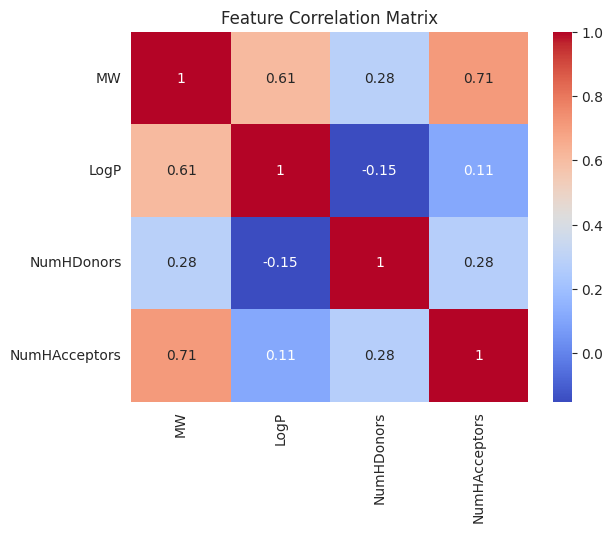

In [ ]:
import numpy as np

sns.heatmap(df_2class[features].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show();

The heatmap shows no strong multicollinearity, which means all these 4 features can be used.

#Tanimoto Similarity

To assess the structural diversity of the dataset, I computed pairwise Tanimoto similarity scores between Morgan fingerprints.

#Why This?

- Tanimoto similarity measures the overlap between two binary fingerprints.

- The histogram shows how structurally similar the compounds are to one another.

- A broad distribution indicates good chemical diversity, which is desirable for robust model training.

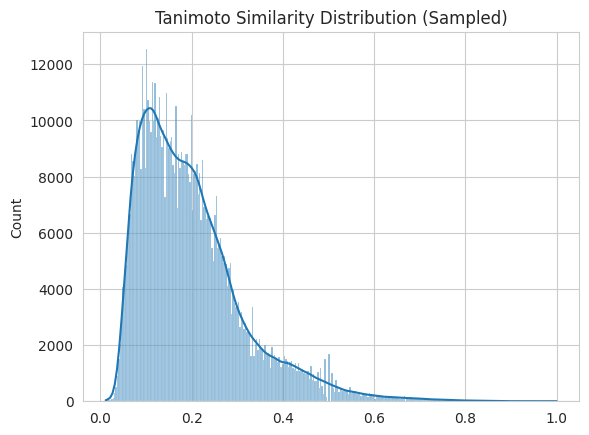

In [ ]:
from rdkit.DataStructs import TanimotoSimilarity
from itertools import combinations

fps = list(df_2class['fp'])
similarities = [TanimotoSimilarity(fps[i], fps[j]) for i, j in combinations(range(len(fps)), 2)]

sns.histplot(similarities, kde=True)
plt.title("Tanimoto Similarity Distribution (Sampled)")
plt.show();

Similarity is concentrated around ~0.1-0.2, which means that my dataset has good chemical diversity.

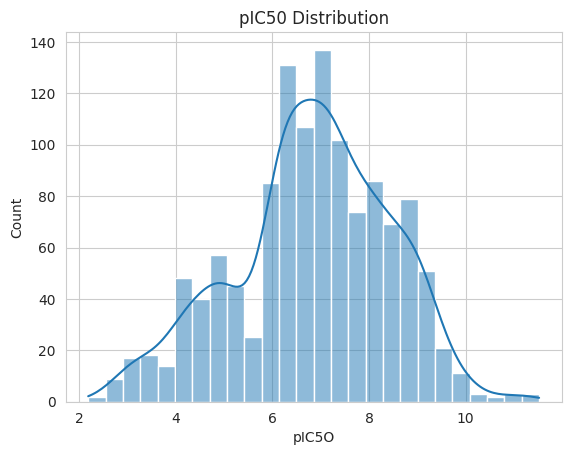

In [ ]:
sns.histplot(df_2class['pIC5O'], kde=True)
plt.title("pIC50 Distribution")
plt.show();

Converting the Morgan Fingerprints into features:

In [ ]:
fp_list = [np.array(fp) for fp in df_2class['fp']]

fp_array = np.vstack(fp_list)

physchem_features = df_2class[['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']].values

X = np.hstack((physchem_features, fp_array))

y = df_2class['bioactivity_class'].apply(lambda x: 1 if x == 'active' else 0).values

Checking...

In [ ]:
print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Positive samples: {np.sum(y)}")
print(f"Negative samples: {len(y) - np.sum(y)}")

Feature shape: (1239, 1028)
Target shape: (1239,)
Positive samples: 1024
Negative samples: 215


Final Dataset:

In [ ]:
fp_cols = [f'fp_{i}' for i in range(fp_array.shape[1])]
phys_cols = ['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']

X_df = pd.DataFrame(np.hstack((physchem_features, fp_array)), columns=phys_cols + fp_cols)
y_df = pd.DataFrame(y, columns=['bioactivity_class'])
final_df = pd.concat([X_df, y_df], axis=1)
final_df.head()

,MW,LogP,NumHDonors,NumHAcceptors,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,...,fp_1015,fp_1016,fp_1017,fp_1018,fp_1019,fp_1020,fp_1021,fp_1022,fp_1023,bioactivity_class
0,383.814,4.45034,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,482.903,3.61432,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,283.287,2.31056,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,164.160,1.49000,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,215.168,1.73096,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


After preprocessing, filtering, and feature extraction, I generated the final dataset containing:

- 4 physicochemical descriptors: MW, LogP, NumHDonors, NumHAcceptors

- 1024 binary Morgan fingerprint bits:
fp_0 to fp_1023

- Target variable:
bioactivity_class (0 = inactive, 1 = active)

The dataset has 1029 columns and was saved as:

In [ ]:
final_df.to_csv("final_bioactivity_data.csv", index=False)

This dataset is now ready for machine learning model training.

